# Can you estimate the age of an abalone?

## 📖 Background
You are working as an intern for an abalone farming operation in Japan. For operational and environmental reasons, it is an important consideration to estimate the age of the abalones when they go to market. 

Determining an abalone's age involves counting the number of rings in a cross-section of the shell through a microscope. Since this method is somewhat cumbersome and complex, you are interested in helping the farmers estimate the age of the abalone using its physical characteristics.

## Abalone characteristics:
- "sex" - M, F, and I (infant).
- "length" - longest shell measurement.
- "diameter" - perpendicular to the length.
- "height" - measured with meat in the shell.
- "whole_wt" - whole abalone weight.
- "shucked_wt" - the weight of abalone meat.
- "viscera_wt" - gut-weight.
- "shell_wt" - the weight of the dried shell.
- "rings" - number of rings in a shell cross-section.
- "age" - the age of the abalone: the number of rings + 1.5.

***Acknowledgments**: Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn, and Wes B Ford (1994) "The Population Biology of Abalone (_Haliotis_ species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North Coast and Islands of Bass Strait", Sea Fisheries Division, Technical Report No. 48 (ISSN 1034-3288).*

# Preliminaries: Imports and Loading Data 

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import empiricaldist as edist
import os

In [160]:
# first let's the location of the data to a variable
data = os.path.join('data', 'abalone.data')

In [161]:
df_train_org = pd.read_csv(data)
df = df_train_org.copy()

In [162]:
# add the missing names:
col_names = ['sex', 'length', "diameter", 'height', 'whole_wt', 'shucked_wt', 'viscera_wt',  "shell_wt", 'rings'] 
# the age of the ablone is estimated as the number  of rings + 1.5
df.columns = col_names

In [163]:
print(df.shape)
print(df.head())

(4176, 9)
  sex  length  diameter  height  whole_wt  shucked_wt  viscera_wt  shell_wt  \
0   M   0.350     0.265   0.090    0.2255      0.0995      0.0485     0.070   
1   F   0.530     0.420   0.135    0.6770      0.2565      0.1415     0.210   
2   M   0.440     0.365   0.125    0.5160      0.2155      0.1140     0.155   
3   I   0.330     0.255   0.080    0.2050      0.0895      0.0395     0.055   
4   I   0.425     0.300   0.095    0.3515      0.1410      0.0775     0.120   

   rings  
0      7  
1      9  
2     10  
3      7  
4      8  


# Data analysis: Rings
In this section, I try to extract as much information as possible about the target variable which is, in our case, number of rings.

In [164]:
df = df.rename(columns={"rings":"y"})
print(df['y'].describe())

count    4176.000000
mean        9.932471
std         3.223601
min         1.000000
25%         8.000000
50%         9.000000
75%        11.000000
max        29.000000
Name: y, dtype: float64


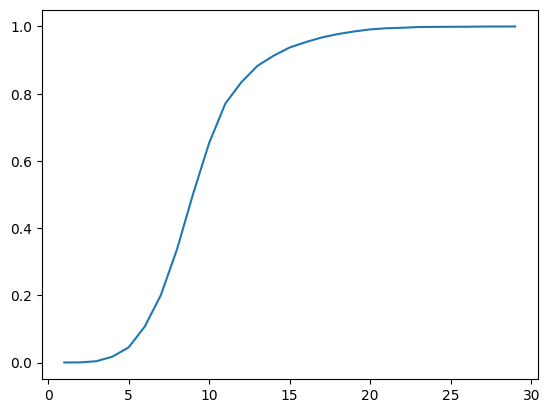

0.04525862068965517
0.9913793103448276


/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


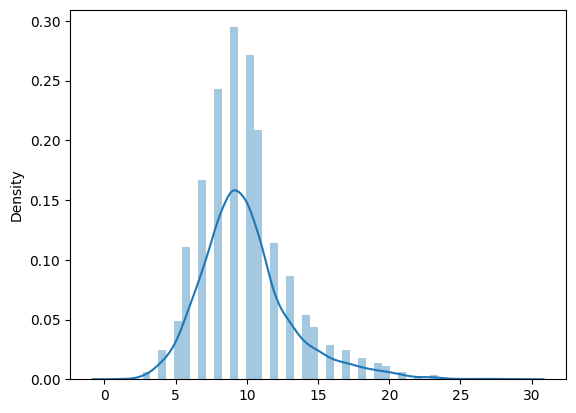

In [165]:
# We can see that the standard deviation is pretty low, most of rings are within +/- rings from average.
# however, it is necessary to visualize the variable's variation to better understand na d /verify our assumptions
from empiricaldist import Cdf
Y = df['y'].copy().values
y_cdf = Cdf.from_seq(Y)
y_cdf.plot()
plt.show()
# let's understand the probability of having less than 5 rings and that of having more than 20 rings
prob_less_5 = y_cdf(5)
prob_more_20 = y_cdf(20)
print(prob_less_5)
print(prob_more_20)

# values less than 5 and larger than 20 can be seen as outliers.
sns.distplot(Y)
plt.show()

It is reasonable to assume that the number of rings is normally distributed.
# Explatory Data Analysis: understanding the most relevant features
To better predict the target variable, it is crucial to understand which of the predictors contribute to this value.

In [166]:
print(np.unique(df['sex']))

['F' 'I' 'M']


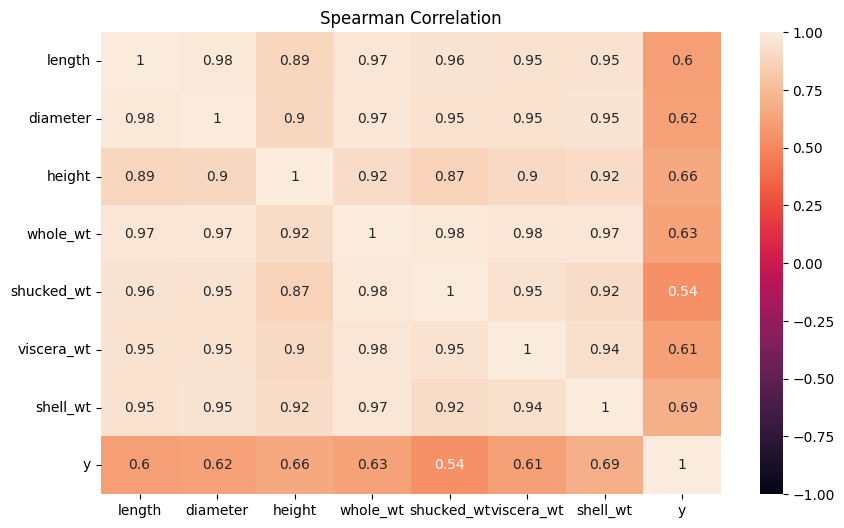

In [167]:
def display_correlation(df):
    r = df.corr(method="spearman")
    plt.figure(figsize=(10,6))
    heatmap = sns.heatmap(r, vmin=-1, 
                      vmax=1, annot=True)
    plt.title("Spearman Correlation")
    return(r)
df_corr = display_correlation(df)


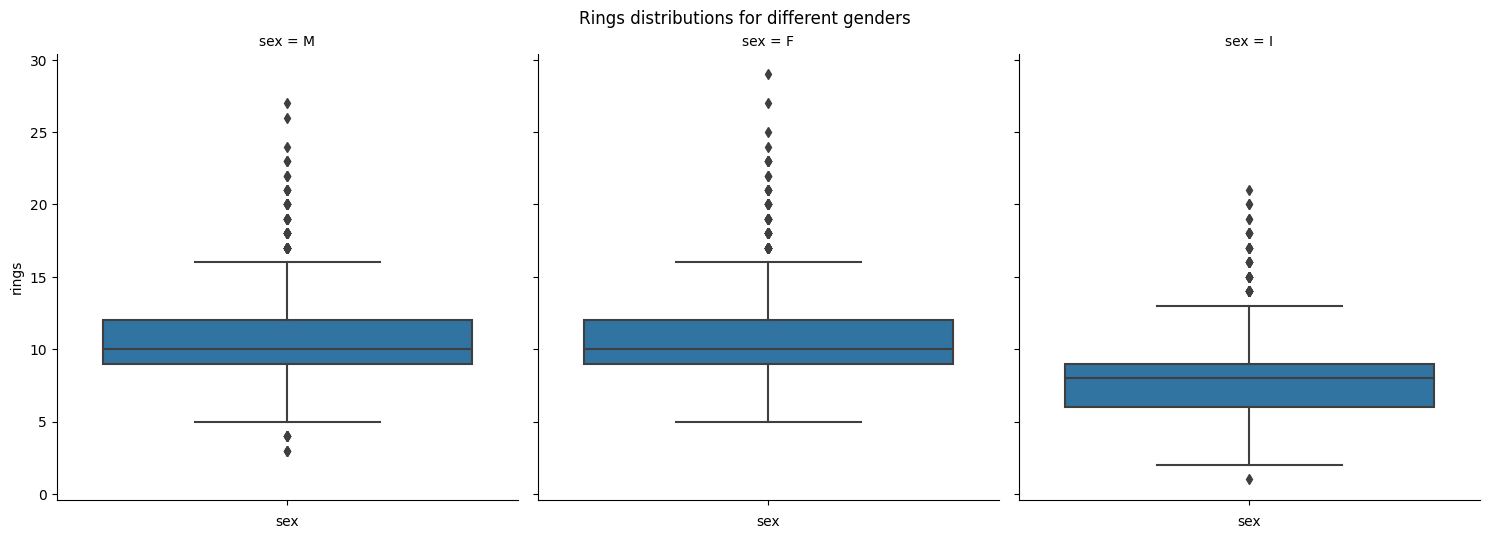

In [168]:
# using the Pearsman's correlation measurements, we can see that all of our initial features are moderately correlated with the target variable.display_correlation
# additionally, it is crucial to note the data suffers from multicollinearity as most features are highly correlated with one another.

# let's also consider its relation to the categorical features
g = sns.catplot(kind='box', data=df, y='y', col='sex', col_order=['M', "F", "I"])
g.fig.suptitle("Rings distributions for different genders", y=1.02)
g.set(xlabel='sex', ylabel='rings')
plt.show()

# Weight with Age:
In this section, I try to understand the variation of The weight with age depending on each sex.

In [169]:
df = df.rename(columns={"whole_wt": "t_wt", "shell_wt": 's_wt'})
M = 'M'
F = 'F'
I = "I"
df['age'] = df['y'] + 1.5
df_m = df[df['sex'] == M]
df_f = df[df['sex'] == F]
df_i = df[df['sex'] == I]
SEX_ORDER = [M, F, I]
weights = ['t_wt', 'shucked_wt', 'viscera_wt', 'shell_wt'] 
p_cols = ['length', 'length', 'diameter']


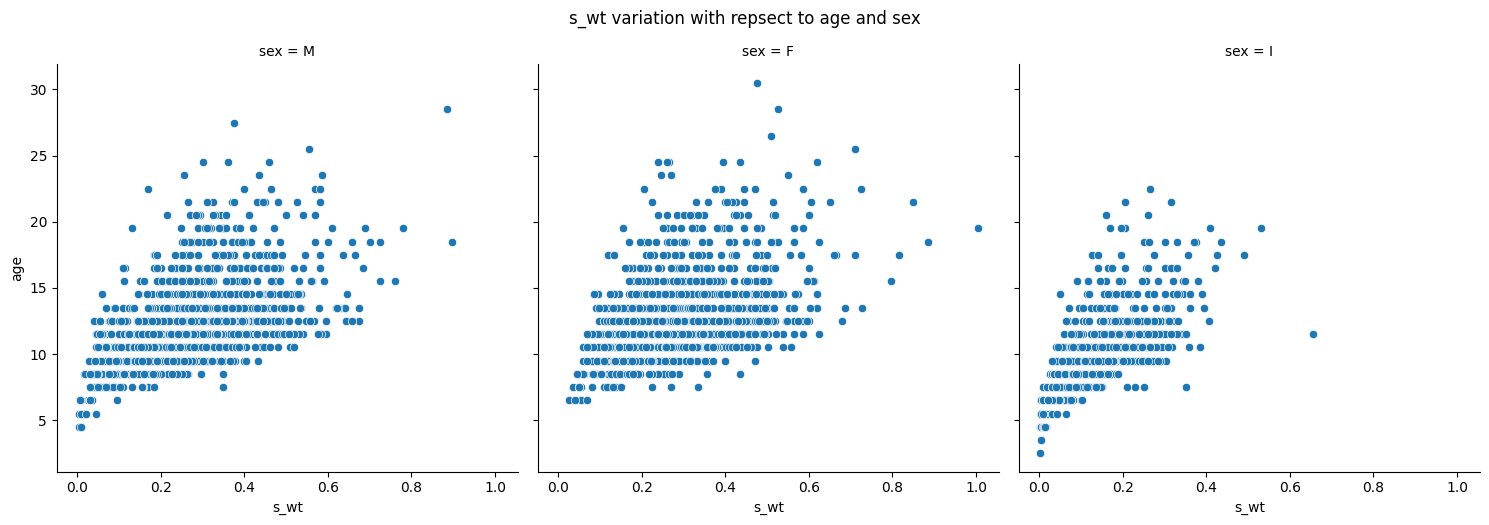

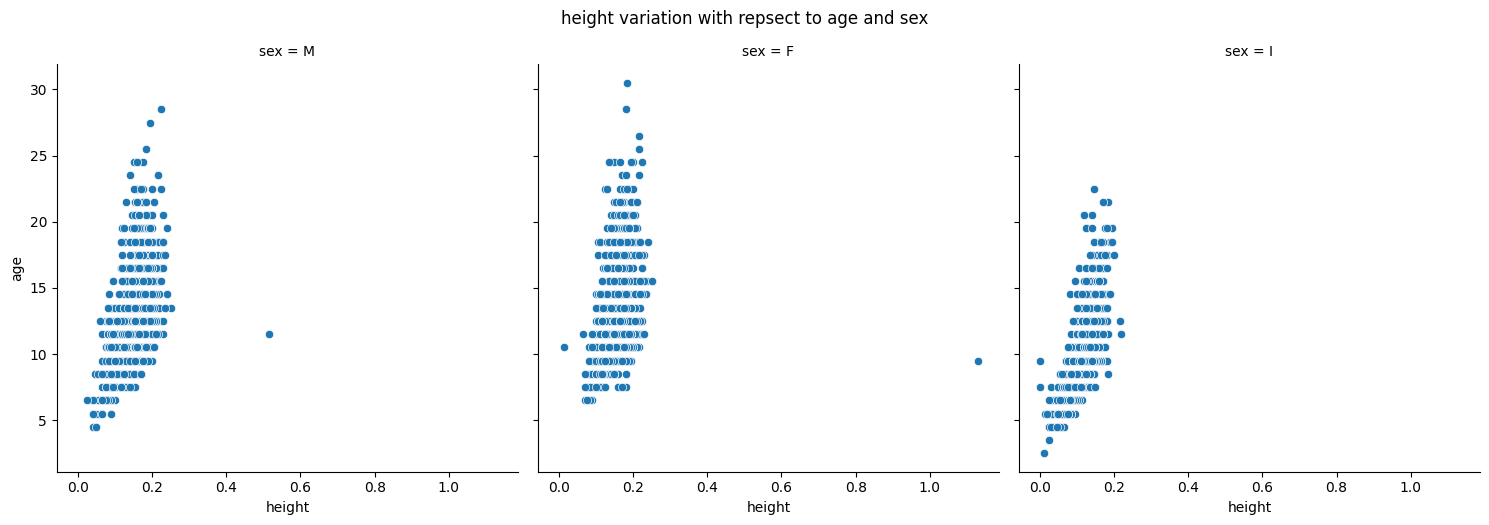

In [171]:

# let's first plot the weight in terms of age for the 3 different genders
def display_variation(df, col1, col2=None, hue=None, hue_order=None):
    assert not (hue is None) ^ (hue_order is None)
    if hue_order is None:
        hue='sex'
        hue_order = SEX_ORDER
    if col2 is None:
        col2 = 'age'    

    g = sns.relplot(kind='scatter', data=df, x=col1, y=col2, col=hue,col_order=hue_order)    
    g.fig.suptitle(f'{col1} variation with repsect to {col2} and {hue}', y=1.04)
    g.set(xlabel=col1, ylabel=col2)

    plt.show()
    return g
# display_variation(df, 'whole_wt')
display_variation(df, 's_wt', 'age', )
display_variation(df, 'height', 'age')

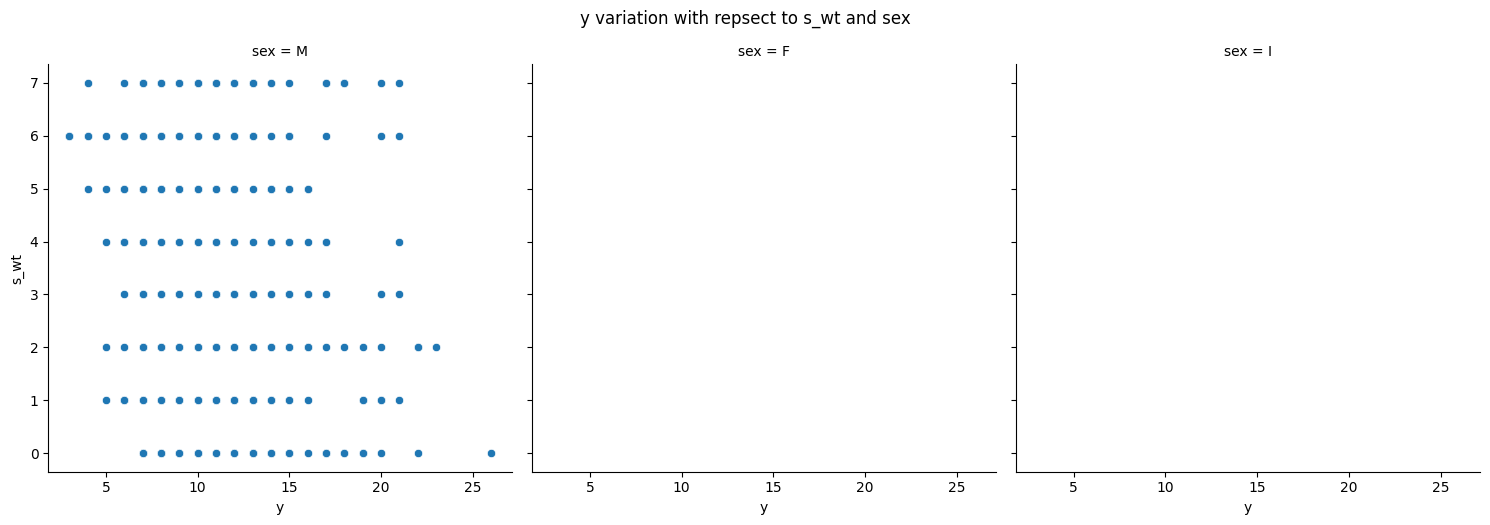

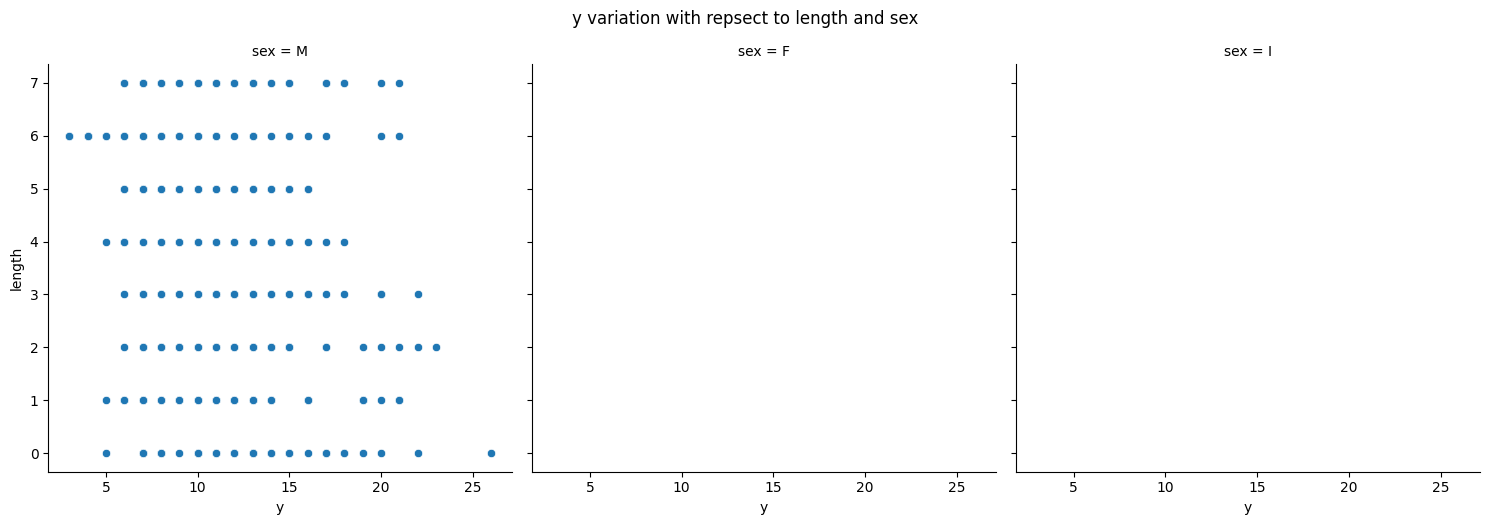

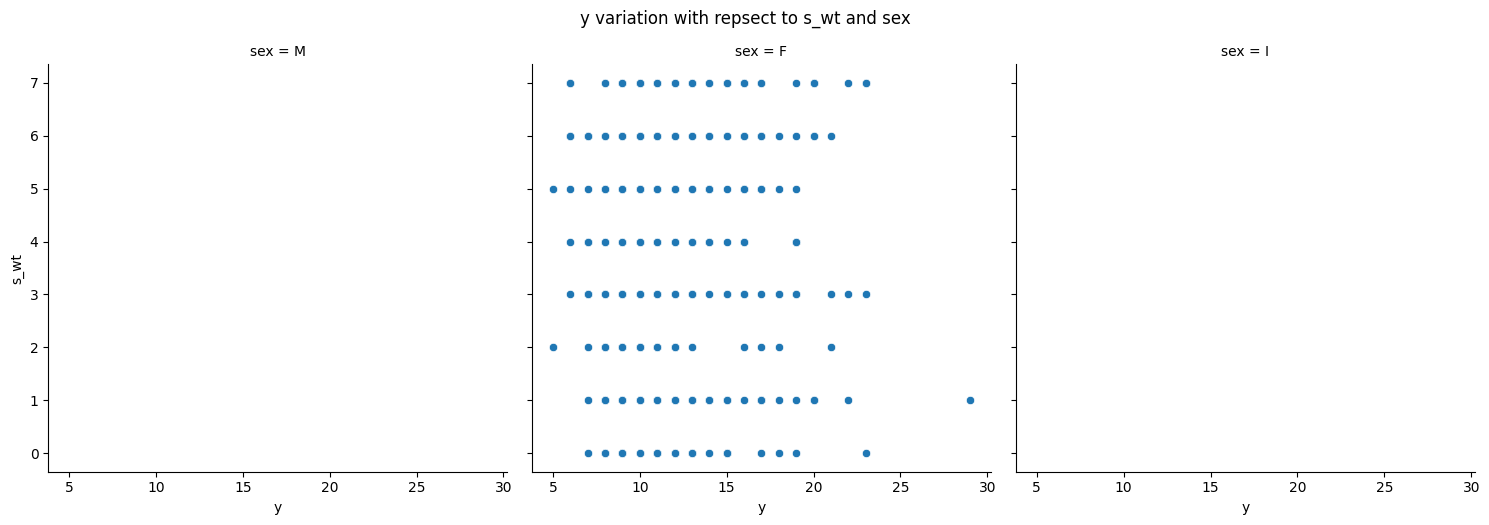

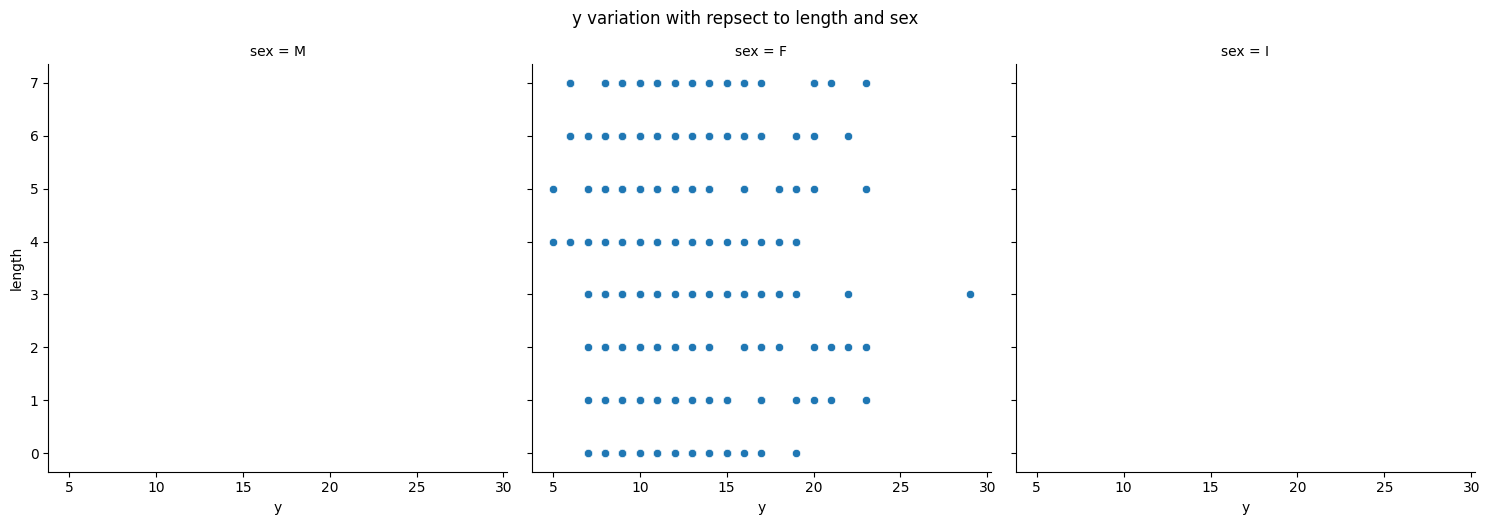

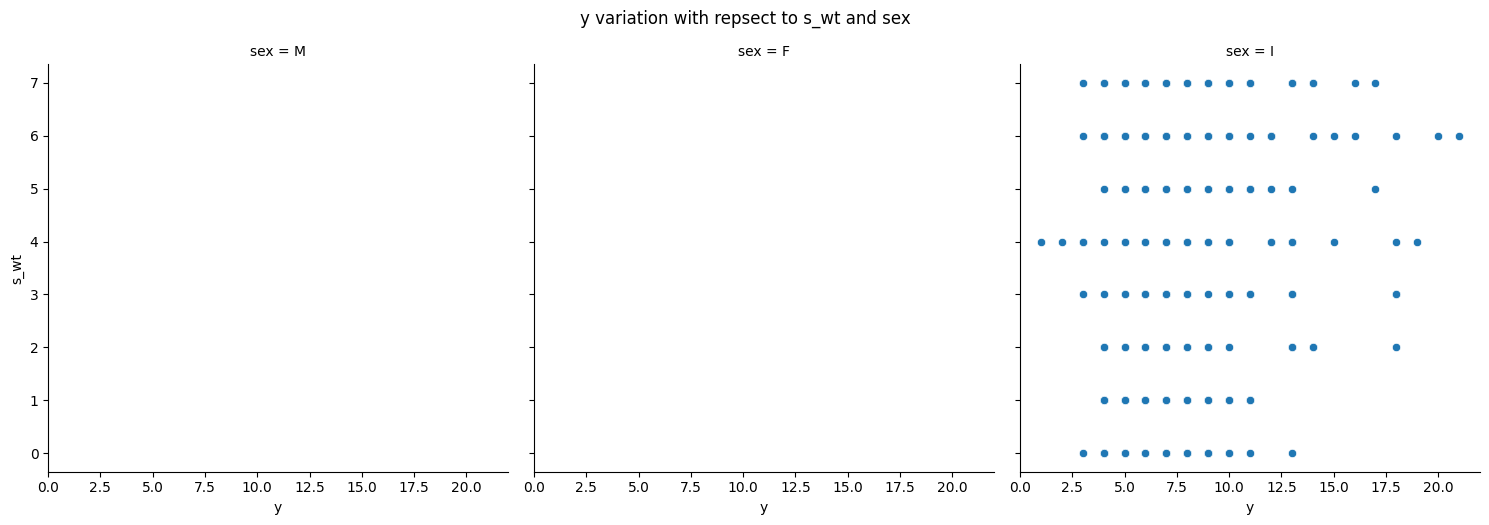

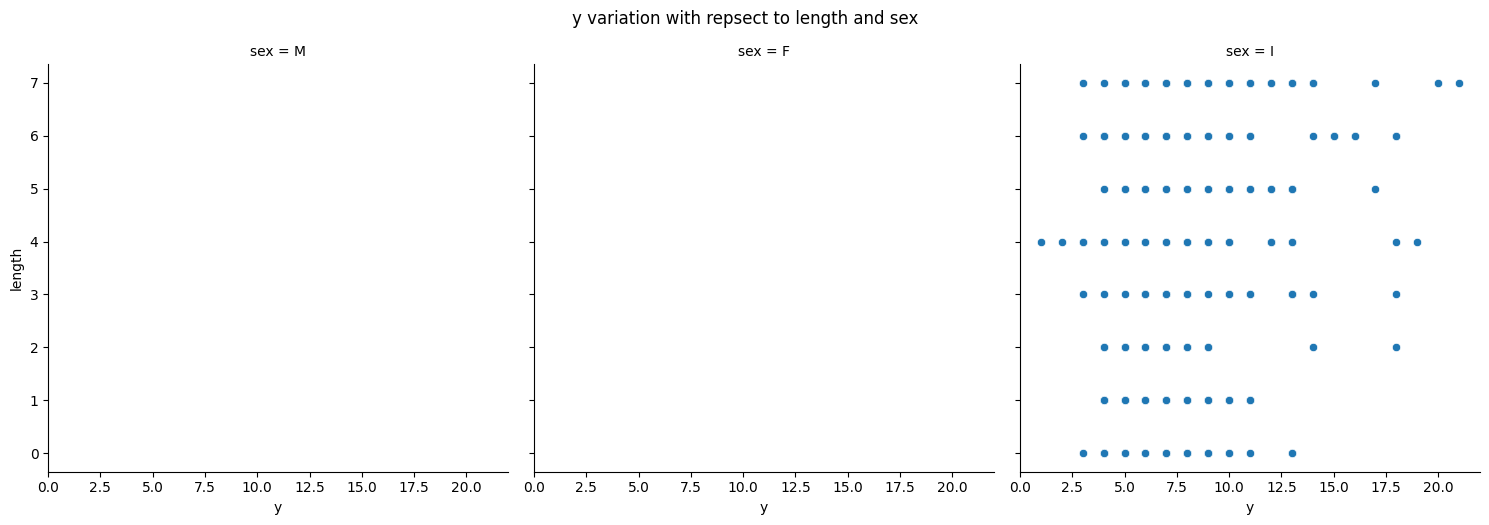

In [179]:
from sklearn.preprocessing import KBinsDiscretizer

def length_weight_dis(df):
    discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
    df_temp = df.loc[:, ['s_wt', 'length']]
    df_temp = pd.DataFrame(data=discretizer.fit_transform(df_temp), columns=['s_wt', 'length'])

    df_temp['y'] = df['y'].copy()
    df_temp['sex'] = df['sex'].copy()

    display_variation(df_temp, 'y', 's_wt')
    display_variation(df_temp, 'y', 'length')

for d in [df_m, df_f, df_i]:
    length_weight_dis(d)

      s_wt  length   y sex
0      0.0     0.0   7   M
1      3.0     3.0   9   F
2      2.0     1.0  10   M
3      0.0     0.0   7   I
4      1.0     1.0   8   I
...    ...     ...  ..  ..
4171   4.0     4.0  11   F
4172   4.0     5.0  10   M
4173   5.0     5.0   9   M
4174   5.0     6.0  10   F
4175   7.0     7.0  12   M

[4176 rows x 4 columns]


,s_wt,length,y
s_wt,1.000000,0.932298,0.686112
length,0.932298,1.000000,0.596427
y,0.686112,0.596427,1.000000


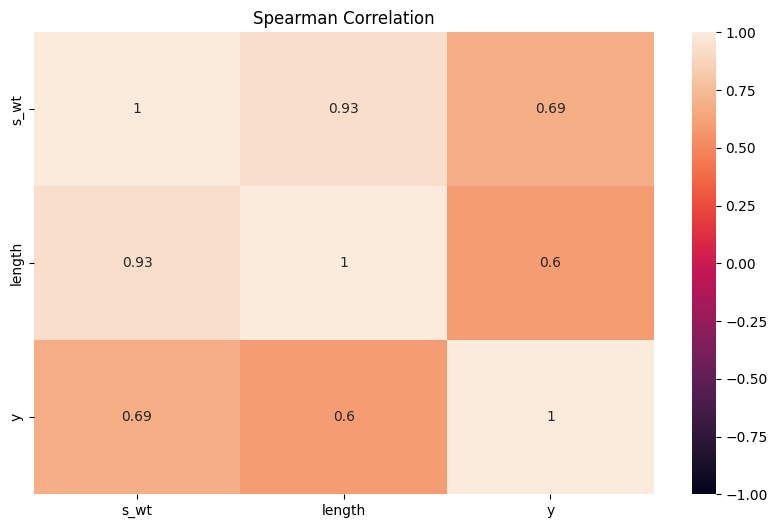

In [175]:
# let's bin each of the length and shell weight and consider them as discrete features then


reduced_feats = ['sex', 's_wt', 'length', 'y']
df_reduced = df.loc[:, reduced_feats].copy()

df_temp = df.loc[:, ['s_wt', 'length']]
df_temp = pd.DataFrame(data=discretizer.fit_transform(df_temp), columns=['s_wt', 'length'])

df_temp['y'] = df['y'].copy()
df_temp['sex'] = df['sex'].copy()



In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# create a dataframe with only weight features and scale it
df_weight = df.loc[:, weights].copy()
w_scaler = StandardScaler()
X_scaled = w_scaler.fit_transform(df_weight)
df_weight = pd.DataFrame(data=X_scaled, columns=weights)

pca_w = PCA(n_components=1)
df_weight = pd.DataFrame(data=pca_w.fit_transform(df_weight), columns=['weight'])
df_weight['y'] = df['y'].copy()
df_weight['sex'] = df['sex'].copy()
display_variation(df_weight, 'weight', 'y')

# display_correlation(df_weight)

In [ ]:
t_wt_age_sex = pd.pivot_table(df, index='y', columns='sex', values='t_wt', aggfunc=['mean', 'median', 'count']).reset_index()
# print(t_wt_age_sex)

for s in SEX_ORDER:
    sns.relplot(kind='line', data=t_wt_age_sex, x='y', y=('mean', s))
plt.legend()
plt.show()

In [ ]:

# weights = ['t_wt', 'shucked_wt', 'viscera_wt', 'shell_wt'] 
# for w in weights:
#     display_variation(df, 'age', w)

In [ ]:
# # let's understand how the weight features vary
# for w in weights:
#     sns.displot(df[w])
#     plt.show()

In [ ]:
# the above graphs indicate that the data is indeed right-skewed. The data might benefit from certain transformations
# let's experiment with a number of them

# I will only test the results of the transformation with the variable weight
# log_w = np.log(df['t_wt'])
# sqrt_wt = np.sqrt(df['t_wt'])
# rec_wt = 1 / (df['t_wt'] + 10 ** (-3))
# from scipy.stats import boxcox 
# bcx_wt, lam_box= boxcox(df['t_wt']) # lam is the best lambda 
# from scipy.stats import yeojohnson 
# yf_wt, lam_yeo = yeojohnson(df['t_wt'])

# trans = [log_w, sqrt_wt, rec_wt, bcx_wt, yf_wt]
# trans_names = ["log", "square root", "inverse", "boxcot", "yeo johnson"]
# for t, n in zip(trans, trans_names):
#     g = sns.displot(t)
#     g.fig.suptitle(f"total weight transformed to {n}", y=1.04)
#     g.set(xlabel=f"{n}(total weight)", ylabel="count")
#     plt.show()

In [ ]:
# the box cot transformation gave the best results.

# def transform_weight(weight_col, mean, lam=lam_box):
#     new_col = (weight_col ** weight_col - 1) / lam  if lam != 0 else np.log(weight_col)
#     return new_col # - 10 * mean

# df['t_wt_bcx'] = bcx_wt
# display_variation(df,'age', 't_wt_bcx')

In [ ]:
# let's consider only the values where the number of instances is signficant enough to infer a relation in general

# display_variation(df, 't_wt', 'length')#, hue='y', hue_order=sorted(np.unique(df_m['y'])))
from scipy.stats import linregress
def weight_vs_physique(df, w_col, p_col):
    
    x = np.log(df[w_col].values)
    y = df[p_col].values
    
    reg_line = linregress(x,y)
    reg_x = np.array([np.min(x), np.max(x)])
    reg_y = reg_line.intercept + reg_line.slope * reg_x
    plt.plot(reg_x, reg_y, color='red')
    
    sns.scatterplot(x=x, y=y, alpha=0.5, color='black')
    plt.xlabel(f'log of {w_col}')
    plt.ylabel(p_col)
    plt.show()


for w in weights:
    for p in p_cols:
        weight_vs_physique(df, w, p)

In [ ]:
# let's consider the collinerity between the physical appearances and logarithm of the weight-related features
